In [1]:
import sys
sys.path.insert(0, '/mnt/deliang-data/projects/CovidDepressionAnalysis/scripts/data_processing')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

import pickle as pkl

from scipy import stats
from sklearn.decomposition import PCA
import seaborn as sns
from constants import *


from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split


import shap
import xgboost
from xgboost import cv

%load_ext autoreload
%autoreload 2



/mnt/deliang-data/.conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
external_baseline = pd.read_csv('../data/css_baseline_demo.tab', sep='\t')

In [3]:
external_data = pd.read_csv('../data/css_panel_2020-2022.tab', sep='\t')
external_data['wave'].unique()
external_data.columns.tolist()

Columns (4,69,80,81,83,89,90,91,92,93,94,95,96,97,98,99,100,159,160,161,162,163,164,165,166,167,168) have mixed types. Specify dtype option on import or set low_memory=False.


['record_id',
 'wave_name',
 'wave',
 'date',
 'week',
 'covid',
 'covidcontact',
 'covidw',
 'covidtest',
 'covidwhen',
 'covidwhen_2',
 'covidexperience',
 'longcovid_symp',
 'longcovid_diag',
 'covidexposure',
 'covidtestjan',
 'covidtestmarch',
 'lcfmob',
 'lcfcog',
 'lcfcar',
 'circumstances1',
 'circumstances2',
 'isolationstatus1',
 'isolationstatus2',
 'isolationstatus3',
 'isolationstatus6',
 'isolationstatus4',
 'isolationstatus5',
 'isolationstatus8',
 'isolationstatus9',
 'isolationstatus7',
 'isolation_new',
 'isolation_reason1',
 'isolation_reason2',
 'isolation_reason3',
 'isolation_reason4',
 'isolation_reason5',
 'isolation_reason6',
 'isolation_reason7',
 'leavinghome1',
 'leavinghome2',
 'leavinghome3',
 'leavinghome4',
 'leavinghome5',
 'leavinghome6',
 'leavinghome7',
 'leavinghome8',
 'leavinghome9',
 'leavinghome10',
 'leavinghome11',
 'leavinghome12',
 'leavinghome1_jan',
 'leavinghome2_jan',
 'leavinghome3_jan',
 'leavinghome4_jan',
 'leavinghome5_jan',
 'leavi

In [4]:
external_data['wave']

0           1
1           2
2           3
3           4
4           5
           ..
1205419     1
1205420     2
1205421     3
1205422     4
1205423    39
Name: wave, Length: 1205424, dtype: int64

In [5]:
external_data['pd_datetime'] = pd.to_datetime(external_data['date'], errors='coerce')

In [6]:
baseline = pd.to_datetime('3/27/2020')
start = pd.to_datetime('4/10/2020')
end = pd.to_datetime('10/10/2020')

In [7]:
external_baseline

,record_id,age,gender,ethnic,marital,education,employment,keyworker1,keyworker2,keyworker3,...,pers7,pers8,pers9,pers10,pers11,pers12,pers13,pers14,pers15,w1wgt
0,1,57,1,1,4,2,5,0,0,0,...,6,5,5,4,7,4,7,1,7,3.21510618032774
1,2,44,2,1,4,6,7,0,0,0,...,4,4,3,1,5,7,7,5,4,.315830276116918
2,3,20,2,1,1,4,1,0,0,0,...,7,7,7,1,7,7,2,6,6,2.17760971978375
3,4,40,1,2,1,4,5,0,0,0,...,4,5,5,7,4,4,4,4,4,3.15036602092718
4,5,60,1,1,4,2,4,0,0,0,...,6,2,5,5,6,5,5,3,2,4.00742924058817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73217,80409,41,2,1,4,6,5,0,0,0,...,5,7,7,4,4,4,6,3,6,.315830276116918
73218,80410,26,2,1,1,5,2,1,0,0,...,7,7,7,2,6,7,6,4,6,.602821949017723
73219,80411,31,2,1,4,6,5,0,0,0,...,5,6,6,6,6,4,5,3,6,.315830276116918
73220,80412,32,2,1,4,5,5,0,0,0,...,5,6,5,4,6,6,6,5,5,.131370831060233


In [8]:
external_baseline['pers1']

0        2
1        5
2        7
3        1
4        1
        ..
73217    7
73218    5
73219    7
73220    4
73221    6
Name: pers1, Length: 73222, dtype: int64

In [9]:
external_baseline['Neuroticism'] = external_baseline.loc[:, UCL_personality['Neuroticism']].sum(axis=1)
external_baseline['Extraversion'] = external_baseline.loc[:, UCL_personality['Extraversion']].sum(axis=1)
external_baseline['Openness'] = external_baseline.loc[:, UCL_personality['Openness']].sum(axis=1)
external_baseline['Agreeableness'] = external_baseline.loc[:, UCL_personality['Agreeableness']].sum(axis=1)
external_baseline['Conscientiousness'] = external_baseline.loc[:, UCL_personality['Conscientiousness']].sum(axis=1)

In [10]:
external_baseline.loc[:, UCL_personality['Neuroticism']].sum(axis=1)

0        10
1        11
2        15
3         7
4         3
         ..
73217    16
73218    17
73219    16
73220    14
73221    19
Length: 73222, dtype: int64

In [11]:
external_baseline['Neuroticism']

0        10
1        11
2        15
3         7
4         3
         ..
73217    16
73218    17
73219    16
73220    14
73221    19
Name: Neuroticism, Length: 73222, dtype: int64

In [12]:
subset = external_data.loc[(external_data['pd_datetime']<end),:].copy()

In [13]:
subset['record_id'].unique()

array([    1,     3,     4, ..., 80411, 80412, 80413])

In [14]:
subset['pd_datetime']

0         2020-03-25
1         2020-04-01
2         2020-04-08
3         2020-04-16
4         2020-04-24
             ...    
1205412   2020-08-28
1205419   2020-05-07
1205420   2020-05-15
1205421   2020-05-23
1205422   2020-06-01
Name: pd_datetime, Length: 739587, dtype: datetime64[ns]

In [15]:
subset['pd_datetime'].unique()

array(['2020-03-25T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2020-04-08T00:00:00.000000000', '2020-04-16T00:00:00.000000000',
       '2020-04-24T00:00:00.000000000', '2020-05-05T00:00:00.000000000',
       '2020-04-23T00:00:00.000000000', '2020-04-30T00:00:00.000000000',
       '2020-05-08T00:00:00.000000000', '2020-05-19T00:00:00.000000000',
       '2020-05-26T00:00:00.000000000', '2020-04-10T00:00:00.000000000',
       '2020-04-19T00:00:00.000000000', '2020-04-26T00:00:00.000000000',
       '2020-05-12T00:00:00.000000000', '2020-05-20T00:00:00.000000000',
       '2020-05-28T00:00:00.000000000', '2020-06-04T00:00:00.000000000',
       '2020-06-13T00:00:00.000000000', '2020-06-20T00:00:00.000000000',
       '2020-06-27T00:00:00.000000000', '2020-07-06T00:00:00.000000000',
       '2020-07-15T00:00:00.000000000', '2020-07-23T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-08-08T00:00:00.000000000',
       '2020-08-16T00:00:00.000000000', '2020-08-24

In [16]:
first_lockdown_time = [pd.to_datetime('3/23/2020'), pd.to_datetime('5/10/2020')]
second_lockdown_time = [pd.to_datetime('9/14/2020'), pd.to_datetime('11/24/2020')]

In [17]:
subset['pd_datetime']

0         2020-03-25
1         2020-04-01
2         2020-04-08
3         2020-04-16
4         2020-04-24
             ...    
1205412   2020-08-28
1205419   2020-05-07
1205420   2020-05-15
1205421   2020-05-23
1205422   2020-06-01
Name: pd_datetime, Length: 739587, dtype: datetime64[ns]

In [18]:
subset.loc[:, 'lockdown'] = ((subset['pd_datetime'] > first_lockdown_time[0]) & (subset['pd_datetime'] < first_lockdown_time[1])) | ((subset['pd_datetime'] > second_lockdown_time[0]) & (subset['pd_datetime'] < second_lockdown_time[1]))

In [19]:
subset['lockdown']

0           True
1           True
2           True
3           True
4           True
           ...  
1205412    False
1205419     True
1205420    False
1205421    False
1205422    False
Name: lockdown, Length: 739587, dtype: bool

In [20]:
subset['depression'] = subset[UCL_depression].replace(' ', np.nan).astype(float).sum(axis=1)

In [21]:
subset['depression']

0           6.0
1           5.0
2           9.0
3           7.0
4           9.0
           ... 
1205412     2.0
1205419    21.0
1205420    10.0
1205421    14.0
1205422    16.0
Name: depression, Length: 739587, dtype: float64

In [22]:
subset['week'] = subset['week'].astype(float)

<Axes: xlabel='week', ylabel='depression'>

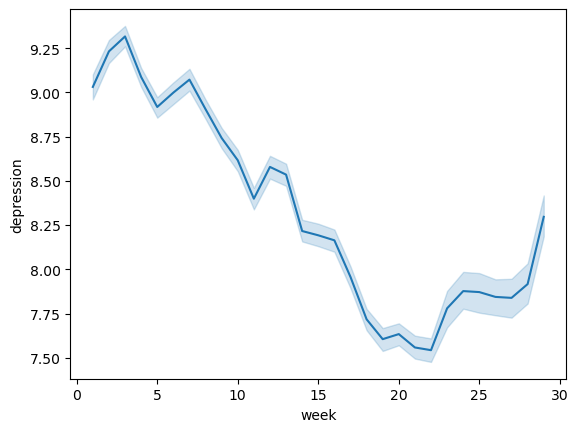

In [23]:
sns.lineplot(data=subset, x='week', y='depression')

<Axes: xlabel='week', ylabel='lockdown'>

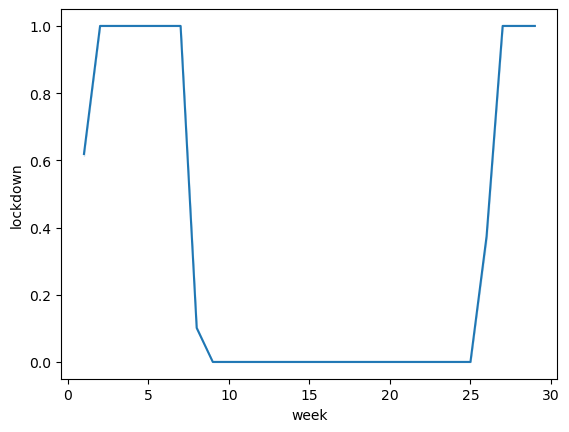

In [24]:
sns.lineplot(data=subset, x='week', y='lockdown')

In [25]:
n_weeks = len(subset['week'].unique())

In [26]:
ids = subset['record_id'].unique().tolist()

n_weeks = len(subset['week'].unique())

print('n participants before filtering:')
print(len(ids))

corrs = []
pvals = []
selected_ids = []

for i in ids:
    lockdown_measures = subset.loc[subset['record_id'] == i, 'lockdown'].values
    depression = subset.loc[subset['record_id'] == i, 'depression'].values
    
    if len(lockdown_measures) >= (0.5 * n_weeks):
        corr, pval = stats.pearsonr(lockdown_measures, depression)
        corrs.append(corr)
        pvals.append(pval)
        selected_ids.append(i)

df = pd.DataFrame({'id': selected_ids, 'corr': corrs, 'pval': pvals})

n participants before filtering:
71544


An input array is constant; the correlation coefficient is not defined.


In [27]:
non_na_df = df.loc[~df['corr'].isna()]

In [28]:
non_na_df

,id,corr,pval
0,4,-0.251476,0.299012
1,5,0.205370,0.359211
2,10,0.137568,0.552075
3,12,-0.092857,0.722991
4,13,0.136957,0.553859
...,...,...,...
27330,80380,0.085480,0.744278
27331,80381,-0.091287,0.727505
27332,80384,-0.310557,0.259921
27333,80387,0.106920,0.682952


In [29]:
negative_participants = non_na_df.loc[(non_na_df['corr'] < 0) & (non_na_df['pval'] <= 0.05)]
positive_participants = non_na_df.loc[(non_na_df['corr'] > 0) & (non_na_df['pval'] <= 0.05)]
neutral_participants = non_na_df.loc[non_na_df['pval'] > 0.05]

In [30]:
neutral_participants

,id,corr,pval
0,4,-0.251476,0.299012
1,5,0.205370,0.359211
2,10,0.137568,0.552075
3,12,-0.092857,0.722991
4,13,0.136957,0.553859
...,...,...,...
27330,80380,0.085480,0.744278
27331,80381,-0.091287,0.727505
27332,80384,-0.310557,0.259921
27333,80387,0.106920,0.682952


In [31]:
positive_participants

,id,corr,pval
6,23,0.446344,0.042536
22,71,0.516568,0.016504
24,74,0.622682,0.007590
25,84,0.451661,0.030504
26,89,0.514173,0.017100
...,...,...,...
27177,79514,0.696366,0.001900
27181,79537,0.683130,0.003535
27289,80173,0.775150,0.000687
27309,80279,0.581666,0.018101


In [32]:
negative_ids = negative_participants['id'].tolist()
positive_ids = positive_participants['id'].tolist()
neutral_ids = positive_participants['id'].tolist()

In [33]:
positive_dep_extraversion = external_baseline.loc[external_baseline['record_id'].isin(negative_ids),'Extraversion'].tolist()
negative_dep_extraversion = external_baseline.loc[external_baseline['record_id'].isin(positive_ids),'Extraversion'].tolist()

In [34]:
positive_dep_neuroticism = external_baseline.loc[external_baseline['record_id'].isin(negative_ids),'Neuroticism'].tolist()
negative_dep_neuroticism = external_baseline.loc[external_baseline['record_id'].isin(positive_ids),'Neuroticism'].tolist()

positive_dep_agreeableness = external_baseline.loc[external_baseline['record_id'].isin(negative_ids),'Agreeableness'].tolist()
negative_dep_agreeableness = external_baseline.loc[external_baseline['record_id'].isin(positive_ids),'Agreeableness'].tolist()

positive_dep_openness = external_baseline.loc[external_baseline['record_id'].isin(negative_ids),'Openness'].tolist()
negative_dep_openness = external_baseline.loc[external_baseline['record_id'].isin(positive_ids),'Openness'].tolist()

positive_dep_conscientiousness = external_baseline.loc[external_baseline['record_id'].isin(negative_ids),'Conscientiousness'].tolist()
negative_dep_conscientiousness = external_baseline.loc[external_baseline['record_id'].isin(positive_ids),'Conscientiousness'].tolist()

In [35]:
stats.ttest_ind(positive_dep_extraversion, negative_dep_extraversion)

Ttest_indResult(statistic=-1.4706405919384042, pvalue=0.1414449890600788)

In [ ]:
stats.ttest_ind(positive_dep_neuroticism, negative_dep_neuroticism)

Ttest_indResult(statistic=-4.479048187277701, pvalue=7.647930215678944e-06)

In [ ]:
stats.ttest_ind(positive_dep_agreeableness, negative_dep_agreeableness)

Ttest_indResult(statistic=-3.386710945148541, pvalue=0.000712270071374352)

In [ ]:
stats.ttest_ind(positive_dep_openness, negative_dep_openness)

Ttest_indResult(statistic=1.0519030713300306, pvalue=0.29288978601047566)

In [ ]:
stats.ttest_ind(positive_dep_conscientiousness, negative_dep_conscientiousness)

Ttest_indResult(statistic=-1.032417629340353, pvalue=0.30192147010943715)

In [ ]:
records = pd.merge(non_na_df, external_baseline, left_on='id', right_on='record_id', how='left')

In [ ]:
records['cls'] = 'positive'
records.loc[(records['corr']<0) & (records['pval']<=0.05), 'cls'] = 'negative'
records.loc[~(((records['corr']>0) & (records['pval']<=0.05)) | ((records['corr']<0) & (records['pval']<=0.05))), 'cls'] = 'neutral'

In [ ]:
records.columns.tolist()

['id',
 'corr',
 'pval',
 'record_id',
 'age',
 'gender',
 'ethnic',
 'marital',
 'education',
 'employment',
 'keyworker1',
 'keyworker2',
 'keyworker3',
 'keyworker4',
 'keyworker5',
 'keyworker6',
 'keyworker7',
 'keyworker8',
 'keyworker9',
 'keyworker10',
 'country',
 'area',
 'region',
 'living',
 'ownership',
 'garden1',
 'garden2',
 'garden3',
 'garden4',
 'rooms',
 'houseadults',
 'housechildren',
 'income',
 'illness1',
 'illness2',
 'illness3',
 'illness4',
 'illness5',
 'illness6',
 'illness7',
 'illness8',
 'illness9',
 'illness12',
 'illness13',
 'illness10',
 'illness11',
 'smoker',
 'alcohol',
 'exercise',
 'caring1',
 'caring2',
 'caring3',
 'pets1',
 'pets2',
 'pets3',
 'pets4',
 'pets5',
 'closefriends',
 'socfreq',
 'pers1',
 'pers2',
 'pers3',
 'pers4',
 'pers5',
 'pers6',
 'pers7',
 'pers8',
 'pers9',
 'pers10',
 'pers11',
 'pers12',
 'pers13',
 'pers14',
 'pers15',
 'w1wgt',
 'Neuroticism',
 'Extraversion',
 'Openness',
 'Agreeableness',
 'Conscientiousness',
 'c

In [ ]:
selected_vars = [   'age',
                    'gender',
                    'ethnic',
                    'marital',
                    'education',
                    'employment',
                    'Neuroticism',
                    'Extraversion',
                    'Openness',
                    'Agreeableness',
                    'Conscientiousness',
                    'cls']

subset = records[selected_vars]

X = subset.drop(['cls'], axis=1)
y = subset['cls'].values == 'negative'

d_X = xgboost.DMatrix(X, label=y)

params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y),
    "eval_metric": "auc"
}

# Perform cross-validation
num_rounds = 10000
num_folds = 5

cv_results = cv(
    params,
    d_X,
    num_boost_round=num_rounds,
    nfold=num_folds,
    early_stopping_rounds=200,
    metrics='auc',
    seed=42,
    verbose_eval=True
)

# Print the cross-validation results
print(cv_results)

[0]	train-auc:0.60257+0.00370	test-auc:0.54846+0.00855
[1]	train-auc:0.62760+0.00464	test-auc:0.55427+0.00459
[2]	train-auc:0.64265+0.00399	test-auc:0.56179+0.00368
[3]	train-auc:0.64995+0.00250	test-auc:0.56621+0.00444
[4]	train-auc:0.65403+0.00306	test-auc:0.57103+0.00664
[5]	train-auc:0.65955+0.00425	test-auc:0.57174+0.00643
[6]	train-auc:0.66442+0.00504	test-auc:0.56912+0.00688
[7]	train-auc:0.66687+0.00627	test-auc:0.57023+0.00622
[8]	train-auc:0.67000+0.00642	test-auc:0.57250+0.00731
[9]	train-auc:0.67147+0.00645	test-auc:0.57340+0.00862
[10]	train-auc:0.67266+0.00614	test-auc:0.57375+0.00934
[11]	train-auc:0.67364+0.00660	test-auc:0.57398+0.01033
[12]	train-auc:0.67559+0.00601	test-auc:0.57428+0.01032
[13]	train-auc:0.67633+0.00581	test-auc:0.57509+0.01000
[14]	train-auc:0.67803+0.00585	test-auc:0.57564+0.00987
[15]	train-auc:0.67822+0.00444	test-auc:0.57575+0.00927
[16]	train-auc:0.67929+0.00468	test-auc:0.57737+0.01025
[17]	train-auc:0.68050+0.00419	test-auc:0.57791+0.00980
[1

[0]	test-auc:0.53718
[100]	test-auc:0.57395
[200]	test-auc:0.56545
[295]	test-auc:0.56724


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


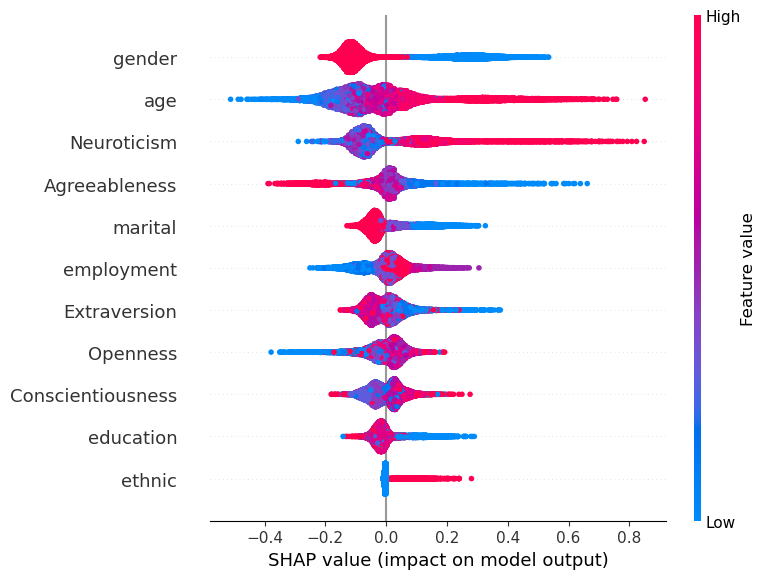

In [135]:
X = subset.drop(['cls'], axis=1)
y = subset['cls'].values == 'negative'


# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "auc"
}
model = xgboost.train(params, d_train, 10000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=200)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [71]:
subset.loc[subset['record_id']==3]

,record_id,wave_name,wave,date,week,covid,covidcontact,covidw,covidtest,covidwhen,...,lifeevent6_2022,lifeevent7_2022,lifeevent8_2022,lifeevent9_2022,lifeevent10_2022,lifeevent11_2022,lifeevent12_2022,pd_datetime,lockdown,depression
7,3,week_1,1,4/23/2020,5,4,1,,,,...,,,,,,,,2020-04-23,True,22.0
8,3,week_2,2,4/30/2020,6,4,3,,,,...,,,,,,,,2020-04-30,True,20.0
9,3,week_3,3,5/8/2020,7,4,3,,,,...,,,,,,,,2020-05-08,True,20.0
10,3,week_4,4,5/19/2020,9,4,3,,,,...,,,,,,,,2020-05-19,False,15.0
11,3,week_5,5,5/26/2020,10,4,1,,,,...,,,,,,,,2020-05-26,False,10.0
